In [44]:
import numpy as np
import pandas as pd
import arviz as az
from scipy.stats import ks_2samp

from src.mcmc import RandomWalk, Barker, SMBarker, MALA, SMMALA

from src.distribution import Rosenbrock

from src.utils.plot import traceplot, acfplot, rosenbrock_pairplot

In [ ]:
def ess(X, rosenbrock):
    idx = ["X_{1}"]

    for j in range(1, rosenbrock.n2 + 1):
        for i in range(2, rosenbrock.n1 + 1):
            idx.append(f"X_{{{j},{i}}}")

    print("Effective Sample Size")

    for i in range(X.shape[0]):
        print("\t", idx[i], ": ", az.ess(X[i, :]))


def quantiles(X_mcmc, rosenbrock):
    quantiles = (0.025, 0.25, 0.5, 0.75, 0.975)

    idx = ["X_{1}"]

    for j in range(1, rosenbrock.n2 + 1):
        for i in range(2, rosenbrock.n1 + 1):
            idx.append(f"X_{{{j},{i}}}")

    X_true = rosenbrock.sample(size=X_mcmc.shape[1])

    df = pd.DataFrame(columns=["0.025", "0.25", "0.5", "0.75", "0.975"])

    for i in range(X_true.shape[0]):
        df.loc["True " + idx[i]] = np.quantile(X_true[i, :], quantiles)
        df.loc["MCMC " + idx[i]] = np.quantile(X_mcmc[i, :], quantiles)

    return df


def ks_distance(X_mcmc, rosenbrock):
    idx = ["X_{1}"]

    for j in range(1, rosenbrock.n2 + 1):
        for i in range(2, rosenbrock.n1 + 1):
            idx.append(f"X_{{{j},{i}}}")

    X_true = rosenbrock.sample(size=X_mcmc.shape[1])

    ks, _ = ks_2samp(X_mcmc, X_true, axis=1)

    print("Kolmogorov-Smirnov Distance")

    for i in range(len(ks)):
        print("\t", idx[i], ": ", ks[i])

In [ ]:
def RWM_proposal(x, step_size):
    return x + step_size * np.random.normal(size=x.shape[0])


def RWM(target, n_iter, x_init, step_size=1):
    target_acceptance = 0.234
    burn_in = 5000
    L = 50
    learning_rate = 0.1

    x = np.asarray(x_init)
    logpi_x = target.logpi(x)

    # (#components, #iterations)
    X = np.empty((x.shape[0], n_iter))

    accepted = list()

    # accepted = 0
    for i in range(burn_in):
        y = RWM_proposal(x, step_size)

        logpi_y = target.logpi(y)

        log_acceptance = logpi_y - logpi_x

        # Acceptance criterion
        if np.log(np.random.uniform(size=1)) < log_acceptance:
            x = y
            logpi_x = logpi_y
            # accepted += 1
            accepted.append(1)
        else:
            accepted.append(0)

        accept_prob = min(1, np.exp(log_acceptance))

        recent_accepts = accepted[-L:]
        accept_rate = sum(recent_accepts) / len(recent_accepts)

        step_size *= np.exp(
            learning_rate
            * (accept_prob - target_acceptance)
            * (1 + np.sqrt(np.abs(accept_rate - target_acceptance)))
        )

        # OPTION 3:
        # if (i + 1) % L == 0:
        #     accept_rate = accepted / L

        #     diff = accept_rate - target_acceptance

        #     if abs(diff) >= 0.05:
        #         step_size *= np.exp(learning_rate * diff * (1 + (abs(diff))))

        #     accepted = 0

        # OPTION 1: Bounds
        # if accept_rate > (target_acceptance + 0.05):
        #     step_size += 0.01
        # elif accept_rate < (target_acceptance - 0.05):
        #     step_size -= -0.01

        # OPTION 2: AM with adaptive scaling
        # acceptance_prob = min(1, np.exp(log_acceptance))
        # step_size = np.exp(np.log(step_size) + learning_rate * (acceptance_prob - target_acceptance))

    accepted = 0
    for i in range(n_iter):
        # Proposal state
        y = RWM_proposal(x, step_size)

        logpi_y = target.logpi(y)

        # Log RWM acceptance rate
        log_acceptance = logpi_y - logpi_x

        # Acceptance criterion
        if np.log(np.random.uniform(size=1)) < log_acceptance:
            x = y
            logpi_x = logpi_y
            accepted += 1

        X[:, i] = x

    acceptance_rate = accepted / n_iter

    return X, acceptance_rate

In [3]:
target = Rosenbrock(n1=2, n2=2)

0.0


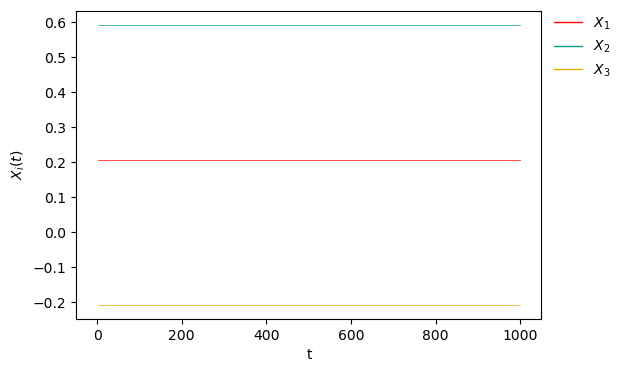

In [51]:
mcmc = RandomWalk()

a = mcmc.sample(
    target=target,
    initial_state=[0, 0, 0],
    n_main_iter=1000,
    n_burnin_iter=1000,
    adapter=adapter,
)

print(a["accept_rate"])
traceplot(a["trace_main"])